In [1]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import utils
import models
import time
import guided_search
%matplotlib inline

Using TensorFlow backend.
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,
/Users/ericcriteser/anaconda2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [2]:
ny_img = image.load_img("n_york.jpg")
ny_array = image.img_to_array(ny_img)
#tee_ny = image.load_img("ny_resized.jpg")
#tee_ny_array = image.img_to_array(tee_ny)

In [3]:
model_width = 224
half_model_width = int(224 * .5)
est_location = 1200
half_est_location = int(est_location * .5)

In [4]:
gcp = [[28826, 1787], [9204,18866], [24343, 10582]]
x, y = int(gcp[2][0]), int(gcp[2][1])

In [5]:
x_start, x_finish, y_start, y_finish = utils.start_lines(x, y, half_est_location)
rand_x_start, rand_y_start = x_start, y_start

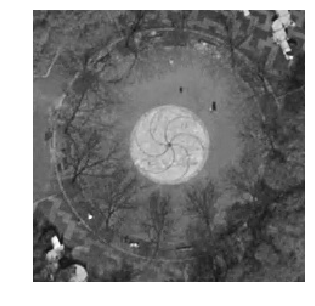

In [6]:
x_img_array = utils.get_img_slice(ny_array, x - half_model_width, y - half_model_width, model_width)
x_img = image.array_to_img(x_img_array)
goal_pred = models.get_pred(x_img)
plt.figure(figsize = (5, 5))
plt.axis('off')
plt.imshow(x_img);

In [7]:
def pix_of_interest(img, goal, num_samples, x, y, est_location, mult):
    rand_x = np.random.randint(x, x + (est_location + half_model_width), num_samples)
    rand_y = np.random.randint(y, y + (est_location + half_model_width), num_samples)
    dist_array = []
    for i in range(len(rand_x)):
        test_slice = utils.get_img_slice(img, rand_x[i], rand_y[i], model_width)
        test_img = image.array_to_img(test_slice)
        dist_array.append(utils.vector_dist(goal, models.get_pred(test_img))[0][0])
    idx = np.argmin(dist_array)
    if dist_array[np.argmin(dist_array): np.argmin(dist_array)+1] < (np.mean(dist_array) - (np.std(dist_array))):
        x, y = utils.return_xy(rand_x, rand_y, np.argmin(dist_array))
        return x, y, np.min(dist_array)
    else:
        print('HELP')
        return pix_of_interest(img, goal, num_samples, x, y, est_location, mult)

In [8]:
def region_of_interest(img, goal, x, y, mult, prev_score, directions):
    results = []
    prev_score = prev_score
    flag_0 = False
    for t in range(0, len(directions)):
        test_slice = utils.get_img_slice(img, x + (directions[t][0]/mult), y + (directions[t][1]/mult), model_width)
        test_img = image.array_to_img(test_slice)
        dist = utils.vector_dist(goal, models.get_pred(test_img))[0][0]
        results.append(dist)
        if dist == 0:
            return results, True
    return results, flag_0

In [9]:
def roi_master(img, goal, x, y, mult, prev_score):
    directions = {0: (-50, 0), 1: (50, 0), 2: (0, -50), 3: (0, 50), 4: (-35, -35), 5: (-35, 35),
                 6: (35, 35), 7: (35, -35)}
    x, y = x, y
    while True:
        prev_score = prev_score
        mult = mult
        results, flag = region_of_interest(img, goal, x, y, mult, prev_score, directions)
        if flag == True:
            x = x + (directions[np.argmin(results)][0]/mult)
            y = y + (directions[np.argmin(results)][1]/mult)
            return x, y, False
        if (np.min(results)) < prev_score:
            prev_score = np.min(results)
            x = x + (directions[np.argmin(results)][0]/mult)
            y = y + (directions[np.argmin(results)][1]/mult)
        elif mult < 64:
            mult = mult*2
        else:
            return x, y, True

In [10]:
def main_search(tee_ny_array, goal_pred, num, rand_x_start, rand_y_start, est_location, mult):
    score = 0
    rand_x_start, rand_y_start = rand_x_start, rand_y_start
    attempts = 0
    while True:
        pred_x, pred_y, score = pix_of_interest(tee_ny_array, goal_pred, num, rand_x_start, rand_y_start, est_location, mult)
        score = score
        pred_x, pred_y, failed_to_converge = roi_master(tee_ny_array, goal_pred, pred_x, pred_y, 1, score)
        attempts += 1
        if not failed_to_converge or attempts > 3:
            return pred_x, pred_y ###Check if return shuts down while

In [11]:
def mc_simulation(num_trials):
    start = time.time()
    rms_s = []
    pixs = []
    times = []
    gcp = [[9204,18866], [24343, 10582], [28826, 1787]] 
    for i in range(num_trials):
        start = time.time()
        if i % 10 == 0:
            print('MC simulation round:', i)
        rand_idx = np.random.randint(0,3)
        x_pix = gcp[rand_idx: rand_idx + 1][0][0]
        y_pix = gcp[rand_idx: rand_idx + 1][0][1]
        x_pix, y_pix = int(x_pix), int(y_pix)
        if rand_idx == 2:
            rand_x_pix = np.random.randint(x_pix - half_est_location, x_pix)
            rand_y_pix = np.random.randint(y_pix, y_pix + half_est_location)
        else:
            rand_x_pix = np.random.randint(x_pix - half_est_location, x_pix + half_est_location)
            rand_y_pix = np.random.randint(y_pix - half_est_location, y_pix + half_est_location)
        x_s, x_f, y_s, y_f = utils.start_lines(rand_x_pix, rand_y_pix, half_est_location)
        t_array = utils.get_img_slice(ny_array, x_pix - half_model_width, y_pix - half_model_width, model_width)
        x_img = image.array_to_img(t_array)
        goal = models.get_pred(x_img)
        try:
            x, y = main_search(ny_array, goal, 40, x_s, y_s, est_location, 1)
            rms = np.sqrt(((x_pix - (x +112))**2) + ((y_pix - (y+112))**2))
            rms_s.append(rms)
            pixs.append([x + 112,y +112])
        except:
            rms_s.append('XXX')
            pixs.append([pix_x, pix_y])
        times.append((time.time()) - start)
    print((time.time()) - start)
    return rms_s, pixs, times
        
#result, points, times = mc_simulation(500)